In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/rangamati_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a correlation matrix
corr_matrix = df_bandarban.corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation test rangamati')
plt.show()

# temperature

## rf

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [ ]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit


rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for temperature:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []
all_importances = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    all_importances.append(rf_model_kf.feature_importances_)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# 3. Calculate the average across all folds
avg_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0) # Bonus: see how stable they are!

# 4. Create the final DataFrame
feature_importance_df_rf = pd.DataFrame({
    'Feature': X.columns,
    'Average_Importance': avg_importance,
    'Std_Dev': std_importance
})

# 5. Sort by the average
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Average_Importance', ascending=False)


diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nRandom Forest Feature Importances (Averaged over all folds):")
print(feature_importance_df_rf)



## rf-lstm

In [ ]:
FEATURES = fourier_cols + lag_cols + rolling_cols

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# --- STEP 1: Selective Features for LSTM ---
# We only give the LSTM the most important "weather" features to reduce noise
# lstm_feature_cols = [
#     'minimum_temperature(degree C)',
#     'temp_lag_1',
#     'temp_roll_7', # 
#     'temp_lag_2', # 
#     'temp_lag_3', # 
#     'atm_roll_7', # 
#     'atm_lag_2', # ~ 1.84 r2
#     'atmospheric_pressure', # r2 -> ~ 1.15
#     'atm_lag_1', # 89.78/90.78 ~ -1
#     'day_of_year_sin_3', # 90.84/91.71 ~ -0.86
#     'atm_lag_3', # 90.79/91.60 ~-0.80 [better]
#     # 'day_of_year_cos_1', # 90.69/91.87 ~-1.18
#     # 'day_of_year_sin_1' # 90.61/91.81 ~-1.20
# ]

lstm_feature_cols = FEATURES

X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections[:, 0]

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final temperature R2: {rf_lstm_r2:.4f}")
print(f"Final temperature MSE: {rf_lstm_mse:.4f}")
print(f"Final temperature RMSE: {rf_lstm_mse:.4f}")
# final r2 90.90/89.87 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace

TEMP = 'temperature(degree C)'
X_full = df[FEATURES]
y_full = df[TEMP]

fold = 1
lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf_model.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf_model.predict(X_train_cv)
    
    # --- STEP 2: Preprocessing for LSTM ---
    # lstm_feature_cols = [
    #     'minimum_temperature(degree C)',
    # 'temp_lag_1',
    # 'temp_roll_7', # 
    # 'temp_lag_2', # 
    # 'temp_lag_3', # 
    # 'atm_roll_7', # 
    # 'atm_lag_2', # ~ 1.84 r2
    # 'atmospheric_pressure', # r2 -> ~ 1.15
    # 'atm_lag_1', # 89.78/90.78 ~ -1
    # 'day_of_year_sin_3', # 90.84/91.71 ~ -0.86
    # 'atm_lag_3', # 90.79/91.60 ~-0.80 [better]
    # ]

    lstm_feature_cols = FEATURES

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 5
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf_model.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")



## xgboost

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [ ]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

'''

'''

targets = y
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_xgb = {}


xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)


print(f"\nXGBoost Results for temperature:")
print(f'Mean Squared Error: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')


# K-Fold cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_xgb = []
r2_list_xgb = [] # Added to track R2 across all folds
mse_list_xgb = []

for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]

        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)

        all_importances.append(xgb_model_kf.feature_importances_)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

        mse_list_xgb.append(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        r2_list_xgb.append(r2_kf_xgb)


        average_rmse_xgb = np.mean(rmse_list_xgb)
        average_r2_xgb = np.mean(r2_list_xgb)
        average_mse_xgb = np.mean(mse_kf_xgb)
        

print ("\n")
print(f"Average RMSE from CV: {average_rmse_xgb:.4f}")
print(f"Average R² from CV: {average_r2_xgb:.4f}")
print(f"Avarage MSE: {average_mse_xgb}")
print(f"Individual Fold RMSEs: {rmse_list_xgb}")

# 3. Calculate the average across all folds
avg_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0) # Bonus: see how stable they are!

# 4. Create the final DataFrame
feature_importance_df_rf = pd.DataFrame({
    'Feature': X.columns,
    'Average_Importance': avg_importance,
    'Std_Dev': std_importance
})

# 5. Sort by the average
feature_importance_df_xgb = feature_importance_df_rf.sort_values(by='Average_Importance', ascending=False)


diff = (r2_xgb - average_r2_xgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)


## light gbm

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [ ]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


''''



'''

targets = y
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}


lgb_model = lgb.LGBMRegressor(
        # n_estimators=800,
        # learning_rate=0.01,
        # max_depth=8,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # random_state=42,
        # verbosity=-1

        n_estimators=300,        # Reduced to prevent memorization as UV r 4k dataset
        learning_rate=0.03,      # Slightly faster learning for fewer trees
        max_depth=6,             # Shallow trees are better for 4k rows
        num_leaves=20,           # Controls complexity
        min_child_samples=40,    # Ensures each "leaf" represents enough data
        subsample=0.7,           # More aggressive sampling for better generalization
        colsample_bytree=0.7,    # Uses 70% of features per tree
        random_state=42,
        verbosity=-1
                              # Clean console
    )

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print(f"\nLightGBM Results for temp:")
print(f'Mean Squared Error: {mse_lgb:.4f}')
print(f'RMSE: {rmse_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')


    # --- 6) 5-fold CV R^2 ---
tscv = TimeSeriesSplit(n_splits=5)
    
rmse_list_lgb = []
r2_list_lgb = []
mse_list_lgb = []


for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        lgb_model_kf = lgb.LGBMRegressor(
            
            n_estimators=300,        # Reduced to prevent memorization
            learning_rate=0.03,      # Slightly faster learning for fewer trees
            max_depth=6,             # Shallow trees are better for 4k rows
            num_leaves=20,           # Controls complexity
            min_child_samples=40,    # Ensures each "leaf" represents enough data
            subsample=0.7,           # More aggressive sampling for better generalization
            colsample_bytree=0.7,    # Uses 70% of features per tree
            random_state=42,
            verbosity=-1             # Clean console
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        all_importances.append(lgb_model_kf.feature_importances_)


        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)
        
        mse_list_lgb.append(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        r2_list_lgb.append(r2_kf_lgb)

        average_rmse_lgb = np.mean(rmse_list_lgb)
        average_r2_lgb = np.mean(r2_list_lgb)
        average_mse_lgb = np.mean(mse_kf_lgb)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_lgb:.4f}")
print(f"Average R² from CV: {average_r2_lgb:.4f}")
print(f"Avarage MSE: {average_mse_lgb}")
print(f"Individual Fold RMSEs: {rmse_list_lgb}")

# 3. Calculate the average across all folds
avg_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0) # Bonus: see how stable they are!

# 4. Create the final DataFrame
feature_importance_df_lgb = pd.DataFrame({
    'Feature': X.columns,
    'Average_Importance': avg_importance,
    'Std_Dev': std_importance
})

# 5. Sort by the average
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Average_Importance', ascending=False)


diff = (r2_lgb - average_r2_lgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLightGBM Feature Importances:")
print(feature_importance_df_lgb)

##### year wise analysis #####
# 1980 to 2024 -> ~ 0.69 (44 years)
# 2014 to 2024 -> ~ 0.82 (10 years)
# 2017 to 2024 -> ~ 0.042 (7 years) **** yey 😂😂😂
# 2018 to 2024 -> ~ 0.78 (6 years)
# 2019 to 2024 -> ~ 1.15 (5 yrs)
# 2021 to 2024 -> ~ 2.33 (3 yrs)

## catboost

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [ ]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split


''''

'''

targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for temp :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)


        all_importances.append(cat_model_kf.feature_importances_)



        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# 3. Calculate the average across all folds
avg_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0) # Bonus: see how stable they are!

# 4. Create the final DataFrame
feature_importance_df_cat = pd.DataFrame({
    'Feature': X.columns,
    'Average_Importance': avg_importance,
    'Std_Dev': std_importance
})

# 5. Sort by the average
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Average_Importance', ascending=False)


diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    


## gru

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [ ]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create an instance with specific parameters
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Wait 15 epochs for improvement before stopping
    restore_best_weights=True  # Very important: keeps the best version of your model
)

# 1. Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for GRU: (samples, time_steps, features)
# Here we use time_steps=1. If you want sequences, you'd need a sliding window function.
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data (matching your non-shuffle 80/20 split)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train initial model
gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
gru_model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping], 
    verbose=1
)

# Predict and Inverse Scale
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

mse_gru = mean_squared_error(y_test_unscaled, y_pred)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_unscaled, y_pred)

print(f"\nGRU Results for temperature :")
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'RMSE: {rmse_gru:.4f}')
print(f'R² Score: {r2_gru:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild/Reset model for each fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = gru_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_gru = np.mean(r2_list_gru)
average_mse_gru = np.mean(mse_list_gru)
average_rmse_gru = np.mean(rmse_list_gru)

print("\n")
print(f"Average RMSE from CV: {average_rmse_gru:.4f}")
print(f"Average R² from CV: {average_r2_gru:.4f}")
print(f"Average MSE: {average_mse_gru:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_gru}")

diff = (r2_gru - np.mean(r2_list_gru))*100
print ( f'\n R2 ~ {diff:.4f}')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

def calculate_permutation_importance_gru(model, X_val, y_val, scaler_y):
    """
    Calculates importance for 3D GRU inputs by shuffling the feature dimension.
    """
    # Baseline prediction
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_inv = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_inv, scaler_y.inverse_transform(baseline_preds))
    
    importances = []
    num_features = X_val.shape[2] # Number of columns in X
    
    for i in range(num_features):
        # Work on a copy to avoid corrupting the original data
        X_permuted = X_val.copy()
        
        # Shuffle the i-th feature across all samples
        # Note: we shuffle the sample order for that specific feature
        shuffled_feature = X_permuted[:, :, i]
        np.random.shuffle(shuffled_feature)
        X_permuted[:, :, i] = shuffled_feature
        
        # Predict and calculate new error
        shuffled_preds = model.predict(X_permuted, verbose=0)
        shuffled_mse = mean_squared_error(y_val_inv, scaler_y.inverse_transform(shuffled_preds))
        
        # Importance is the delta in MSE
        importances.append(max(0, shuffled_mse - baseline_mse))
        
    return np.array(importances)

# --- Cross-Validation Loop ---
tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []
all_fold_importances = [] # Store importances from each fold

for fold, (train_index, test_index) in enumerate(tscv.split(X_reshaped)):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild and train model for this fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Calculate Standard Metrics
    y_pred_kf_scaled = gru_kf.predict(X_test_kf, verbose=0)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

    # --- Permutation Importance for this fold ---
    print(f"Processing Fold {fold+1} Importance...")
    fold_importance = calculate_permutation_importance_gru(gru_kf, X_test_kf, y_test_kf, scaler_y)
    all_fold_importances.append(fold_importance)

# --- Aggregate Results ---
avg_importance = np.mean(all_fold_importances, axis=0)
std_importance = np.std(all_fold_importances, axis=0)

# Create Final Importance DataFrame
# Assuming 'X' is your original dataframe to get feature names
feature_importance_gru = pd.DataFrame({
    'Feature': X.columns,
    'Average_Importance': avg_importance,
    'Std_Dev': std_importance
}).sort_values(by='Average_Importance', ascending=False)

# Final Reporting
print("\n--- GRU Final Results ---")
print(f"Average RMSE from CV: {np.mean(rmse_list_gru):.4f}")
print(f"Average R² from CV: {np.mean(r2_list_gru):.4f}")
print("\nGRU Permutation Feature Importances (Averaged):")
print(feature_importance_gru)

## lstm

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [ ]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np

# --- 1. Scaling and Reshaping (Fix for image_d61d81.png) ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale 2D data first
X_scaled = scaler_X.fit_transform(X) 
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Now reshape to 3D for LSTM
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))


# Split matching your CatBoost logic (shuffle=False)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model


# Initial Training
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)



# Predictions & Inverse Scaling
y_pred_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\nLSTM Results for temp :")
print(f'Mean Squared Error: {mse_lstm:.4f}')    
print(f'RMSE: {rmse_lstm:.4f}')
print(f'R² Score: {r2_lstm:.4f}')









# --- 2. Permutation Logic ---
def get_permutation_importance_fold(model, X_val, y_val, scaler_y):
    # Baseline
    baseline_preds = model.predict(X_val, verbose=0)
    # Fix for image_d6383f: Ensure scaler_y is used only after fit_transform is called
    y_val_unscaled = scaler_y.inverse_transform(y_val.reshape(-1, 1))
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds.reshape(-1, 1)))
    
    fold_imps = []
    for i in range(X_val.shape[2]):
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, :, i])
        
        perm_preds = model.predict(X_permuted, verbose=0)
        perm_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(perm_preds.reshape(-1, 1)))
        fold_imps.append(max(0, perm_mse - baseline_mse))
    return fold_imps

# --- 3. CV Loop (Fix for image_d462c2.png) ---
tscv = TimeSeriesSplit(n_splits=5)
rmse_list_lstm, r2_list_lstm, mse_list_lstm, all_fold_importances = [], [], [], []

print("Starting Cross-Validation...")

# Important: split on X_reshaped (the NumPy array) to avoid KeyErrors
for train_index, test_index in tscv.split(X_reshaped):
    # NumPy indexing works perfectly here
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    lstm_kf = build_lstm((X_train_kf.shape[1], X_train_kf.shape[2]))
    lstm_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Prediction and Evaluation
    y_pred_kf_scaled = lstm_kf.predict(X_test_kf, verbose=0)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled.reshape(-1, 1))
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf.reshape(-1, 1))

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_lstm.append(np.sqrt(mse_kf))
    mse_list_lstm.append(mse_kf)
    r2_list_lstm.append(r2_score(y_test_kf_unscaled, y_pred_kf))
    
    fold_importance = get_permutation_importance_fold(lstm_kf, X_test_kf, y_test_kf, scaler_y)
    all_fold_importances.append(fold_importance)

# --- 4. Aggregates ---
lstm_importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Average_Importance': np.mean(all_fold_importances, axis=0),
    'Std_Dev': np.std(all_fold_importances, axis=0)
}).sort_values(by='Average_Importance', ascending=False)

average_r2_lstm = np.mean(r2_list_lstm)
average_mse_lstm = np.mean(mse_list_lstm)
average_rmse_lstm = np.mean(rmse_list_lstm)
 
print("\n")
print(f"Average RMSE from LSTM CV: {average_rmse_lstm:.4f}")
print(f"Average R² from LSTM CV: { average_r2_lstm:.4f}")
print(f"Average MSE: {average_mse_lstm:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_lstm}")


print("\nTop Importances:")
print(lstm_importance_df.head())

## ann

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]




In [ ]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for temperature :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

## cnn-lstm

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [ ]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['temperature(degree C)'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")
print ()

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
# from keras.optimizers import Adam

# # 1. DATA PREPARATION (Multivariate)
# window = 30
# # Combine all features and the target into one array
# data_all = df[FEATURES + ['temperature(degree C)']].values

# def create_sequences_multivariate(data, window_size):
#     X, y = [], []
#     for i in range(len(data) - window_size):
#         # All columns except the last one are features
#         X.append(data[i:(i + window_size), :-1]) 
#         # The last column is the target (temperature)
#         y.append(data[i + window_size, -1]) 
#     return np.array(X), np.array(y)

# X, y = create_sequences_multivariate(data_all, window)

# # Split into Train and Test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # 2. UPDATED HYBRID MODEL
# def build_hybrid_multivariate(input_shape):
#     model = Sequential([
#         # input_shape will be (30, 18)
#         Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
#         Dropout(0.2),

#         LSTM(64, activation='tanh', return_sequences=False), 
#         Dropout(0.2),

#         Dense(32, activation='relu'),
#         Dropout(0.1),
#         Dense(1)
#     ])
    
#     optimizer = Adam(learning_rate=0.0005)
#     model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#     return model

# # Initialize and train
# model = build_hybrid_multivariate((window, len(FEATURES)))
# model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# # 3. PERMUTATION IMPORTANCE WITH STD DEV
# def get_permutation_importance(model, X_val, y_val, feature_names):
#     base_preds = model.predict(X_val, verbose=0)
#     base_rmse = np.sqrt(mean_squared_error(y_val, base_preds))
    
#     importance_results = []

#     for i, col_name in enumerate(feature_names):
#         scores = []
#         # Run 5 times to get Standard Deviation
#         for run in range(5):
#             X_shuffled = X_val.copy()
#             # Shuffle only the specific feature across all samples and time steps
#             # We shuffle the 'depth' slice corresponding to feature i
#             shuffled_feature = np.random.permutation(X_shuffled[:, :, i].flatten())
#             X_shuffled[:, :, i] = shuffled_feature.reshape(X_shuffled.shape[0], X_shuffled.shape[1])
            
#             shuff_preds = model.predict(X_shuffled, verbose=0)
#             shuff_rmse = np.sqrt(mean_squared_error(y_val, shuff_preds))
#             scores.append(shuff_rmse - base_rmse)
        
#         importance_results.append({
#             'Feature': col_name,
#             'Average_Importance': np.mean(scores),
#             'Std_Dev': np.std(scores)
#         })
#         print(f"Computed importance for: {col_name}")

#     return pd.DataFrame(importance_results).sort_values(by='Average_Importance', ascending=False)

# # Run the importance check
# importance_df_hybrid = get_permutation_importance(model, X_test, y_test, FEATURES)

# print("\n--- Hybrid Model Feature Importance (Averaged) ---")
# print(importance_df_hybrid)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # Added for normalization
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# 1. SCALING AND DATA PREPARATION
window = 30
# Initialize scalers for features (X) and target (y)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale features and target separately
scaled_features = scaler_X.fit_transform(df[FEATURES])
scaled_target = scaler_y.fit_transform(df[['temperature(degree C)']])

# Combine scaled data back for sequence creation
data_all_scaled = np.hstack((scaled_features, scaled_target))

def create_sequences_multivariate(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), :-1]) 
        y.append(data[i + window_size, -1]) 
    return np.array(X), np.array(y)

X, y = create_sequences_multivariate(data_all_scaled, window)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 2. UPDATED HYBRID MODEL (No changes needed to architecture)
def build_hybrid_multivariate(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

model = build_hybrid_multivariate((window, len(FEATURES)))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 3. PERFORMANCE EVALUATION (With Inverse Scaling)
y_pred_scaled = model.predict(X_test)
# Convert predictions and actuals back to original Celsius values
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

mse_final = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_final = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"\nRescaled Results: R2: {r2_final:.4f}, RMSE: {np.sqrt(mse_final):.4f}")

# 4. PERMUTATION IMPORTANCE (Standard logic remains)
def get_permutation_importance(model, X_val, y_val, feature_names):
    base_preds = model.predict(X_val, verbose=0)
    base_rmse = np.sqrt(mean_squared_error(y_val, base_preds))
    importance_results = []

    for i, col_name in enumerate(feature_names):
        scores = []
        for run in range(5):
            X_shuffled = X_val.copy()
            shuffled_feature = np.random.permutation(X_shuffled[:, :, i].flatten())
            X_shuffled[:, :, i] = shuffled_feature.reshape(X_shuffled.shape[0], X_shuffled.shape[1])
            shuff_preds = model.predict(X_shuffled, verbose=0)
            shuff_rmse = np.sqrt(mean_squared_error(y_val, shuff_preds))
            scores.append(shuff_rmse - base_rmse)
        
        importance_results.append({
            'Feature': col_name,
            'Average_Importance': np.mean(scores),
            'Std_Dev': np.std(scores)
        })
        print(f"Computed importance for: {col_name}")

    return pd.DataFrame(importance_results).sort_values(by='Average_Importance', ascending=False)

importance_df_hybrid = get_permutation_importance(model, X_test, y_test, FEATURES)
print("\n--- Hybrid Model Feature Importance ---")
print(importance_df_hybrid)

In [ ]:
import pandas as pd
import numpy as np

def predict_next_7_days_scaled(model, df, features, scaler_X, scaler_y, window_size=30):
    # 1. Get the last window of data and scale it
    # We use the already fitted scaler_X
    last_raw_data = df[features].tail(window_size).values
    current_batch = scaler_X.transform(last_raw_data) 
    current_batch = current_batch.reshape((1, window_size, len(features)))
    
    future_predictions_scaled = []
    
    # 2. Recursive Prediction Loop
    for i in range(7):
        # Predict (this gives the negative/scaled number)
        next_pred_scaled = model.predict(current_batch, verbose=0)[0, 0]
        future_predictions_scaled.append(next_pred_scaled)
        
        # 3. Update the window
        # Create a new row for the next step
        # Note: For a true forecast, we'd need to update lags/fourier manually.
        # For this block, we shift the window and carry over the last feature state.
        new_row = current_batch[:, -1:, :].copy()
        
        # Shift: Remove oldest day, append the newest "predicted" state
        next_step = np.append(current_batch[:, 1:, :], new_row, axis=1)
        current_batch = next_step

    # 4. INVERSE TRANSFORM: The magic step that fixes the "lol" values
    future_predictions_scaled = np.array(future_predictions_scaled).reshape(-1, 1)
    final_temperatures = scaler_y.inverse_transform(future_predictions_scaled)
    
    # 5. Create the DataFrame
    last_date = pd.to_datetime(df['date']).max()
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)
    
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Predicted_Temperature(C)': final_temperatures.flatten()
    })
    
    return forecast_df

# --- EXECUTION ---
# Make sure model, scaler_X, and scaler_y are defined from your previous part 2 block
forecast_results = predict_next_7_days_scaled(model, df, FEATURES, scaler_X, scaler_y)

print("\n--- Final Corrected Temperature Forecast ---")
print(forecast_results)

## model chart temperature

In [ ]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [False, True])

df_performance

## best model temp

In [ ]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'MSE': 0.3,
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['MSE'].rank(ascending=True) * weights['MSE'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE']  +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")

# humidity

In [13]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/rangamati_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

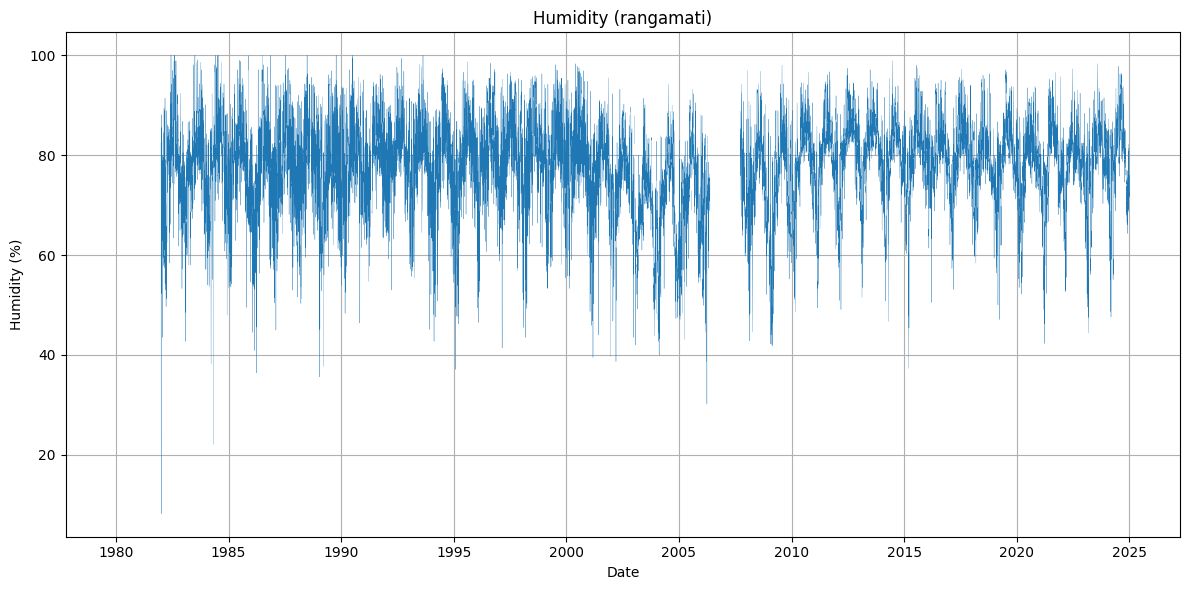

In [21]:
import matplotlib.pyplot as plt

if 'date' not in df_bandarban.columns:
    df_bandarban['date'] = pd.to_datetime(df_bandarban[['year', 'month', 'day']])

# df_bandarban = df_bandarban[
#     (df_bandarban['date'] >= '2024-01-01') & (df_bandarban['date'] <= '2024-12-31')
# ]

min_date = df_bandarban['date'].min()
max_date = df_bandarban['date'].max()

plt.figure(figsize=(12, 6))
plt.plot(df_bandarban['date'], df_bandarban['humidity'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Humidity (rangamati)')
plt.grid(True)
plt.tight_layout()
plt.show()

# feateare engineroah  humidity 

In [15]:
# from sklearn.model_selection import train_test_split
# import numpy as np

# df = df_bandarban.copy()
# if 'date' not in df.columns:
#     df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# # 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# # adding lagging for 3 days
# lags = [7, 8, 9]
# lag_cols = []

# for lag in lags:
#     df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
#     df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
#     df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
#     df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
#     df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
#     lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# # 7-day Rolling Average
# df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
# df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean().shift(7))
# df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean().shift(7))
# df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
# df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean().shift(7))


# rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


# df = df.dropna().reset_index(drop=True)


# df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
# df = df.sort_values('date').reset_index(drop=True)

# df['day_of_year'] = df['date'].dt.dayofyear

# def add_fourier_features(df,col,period,n_terms=3):
#     for n in range(1, n_terms + 1):
#         df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
#         df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
#     return df

# df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
# fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [16]:

# FEATURES = fourier_cols + lag_cols + rolling_cols 

# X = df[FEATURES]
# y = df['humidity']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [17]:
#######################################################################

1. Addressing the Temporal Gaps

In [18]:
#### 1. Addressing the Temporal Gaps

# 1. Ensure a continuous daily index
df_bandarban['date'] = pd.to_datetime(df_bandarban[['year', 'month', 'day']])
df_bandarban = df_bandarban.sort_values('date').set_index('date')

# Create a full date range from 1980 to 2024
full_range = pd.date_range(start=df_bandarban.index.min(), end=df_bandarban.index.max(), freq='D')
df_clean = df_bandarban.reindex(full_range)

# 2. Interpolate small gaps (up to 7 days)
# Large gaps (like 2007) will remain NaN so we can drop them properly later

df = df_clean.interpolate(method='linear', limit=7)

2. Removing Outliers (Sensor Noise)

In [19]:
# 3. Detect and handle outliers using a rolling 3-sigma window
rolling_mean = df['humidity'].rolling(window=30, center=True).mean()
rolling_std = df['humidity'].rolling(window=30, center=True).std()

# Replace values outside 3 standard deviations with the rolling mean
outlier_mask = (df['humidity'] - rolling_mean).abs() > (3 * rolling_std)
df.loc[outlier_mask, 'humidity'] = rolling_mean[outlier_mask]

# Drop the remaining large gaps (the 2007 period) to keep the sequences "real"
df = df.dropna().reset_index().rename(columns={'index': 'date'})

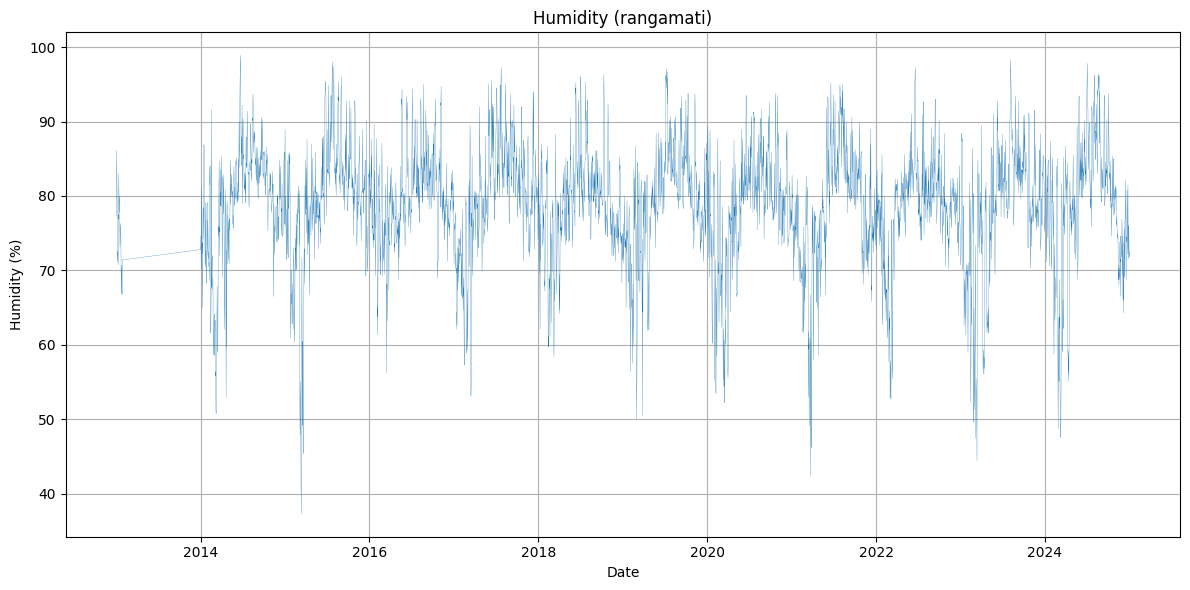

In [20]:
import matplotlib.pyplot as plt

if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# df_bandarban = df_bandarban[
#     (df_bandarban['date'] >= '2024-01-01') & (df_bandarban['date'] <= '2024-12-31')
# ]

min_date = df['date'].min()
max_date = df['date'].max()

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['humidity'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Humidity (rangamati)')
plt.grid(True)
plt.tight_layout()
plt.show()

3. Stationarity Check (ADF Test)

In [ ]:
# from statsmodels.tsa.stattools import adfuller

# result = adfuller(df['humidity'].dropna())
# print(f'ADF Statistic: {result[0]}')
# print(f'p-value: {result[1]}')

# if result[1] > 0.05:
#     print("Series is non-stationary. We should consider differencing.")
# else:
#     print("Series is stationary. Raw values are likely safe for the CNN-LSTM.")

Fragmanet two

1. Physics-Based Feature: Vapor Pressure Deficit (VPD)

In [ ]:
# import numpy as np

# # Saturated Vapor Pressure (es) - how much moisture the air COULD hold
# df['es'] = 0.61078 * np.exp((17.27 * df['temperature(degree C)']) / (df['temperature(degree C)'] + 237.3))

# # Actual Vapor Pressure (ea) - based on the dew point
# df['ea'] = 0.61078 * np.exp((17.27 * df['dew_point']) / (df['dew_point'] + 237.3))

# # VPD is the deficit. A high VPD means the air is very 'thirsty' (low humidity).
# df['VPD'] = df['es'] - df['ea']

2. Interaction & Thermal Features

In [ ]:
# # Solar-Thermal Interaction: Combines the two strongest negative correlations
# df['solar_thermal_idx'] = df['solar_radiation'] * df['temperature(degree C)']

# # Diurnal Temperature Range: Large swings often correlate with drier air masses
# df['temp_range'] = df['max_temperature(degree C)'] - df['minimum_temperature(degree C)']

3. Multi-Step Target Engineering (The 7-Day Lead)

In [ ]:
# # Create 7 target columns: target_1 (tomorrow) through target_7 (next week)
# target_cols = []
# for i in range(1, 8):
#     col_name = f'target_d{i}'
#     df[col_name] = df['humidity'].shift(-i)
#     target_cols.append(col_name)

# # Drop the last 7 rows where we have no future 'ground truth' to train on
# df = df.dropna().reset_index(drop=True)

4. cyclic encoding

In [ ]:
# from sklearn.model_selection import train_test_split
# import numpy as np

# df = df_bandarban.copy()
# if 'date' not in df.columns:
#     df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# # 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# # adding lagging for 3 days
# lags = [7, 8, 9]
# lag_cols = []

# for lag in lags:
#     df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
#     df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
#     df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
#     df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
#     df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
#     lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# # 7-day Rolling Average
# df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
# df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean().shift(7))
# df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean().shift(7))
# df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
# df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean().shift(7))


# rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


# df = df.dropna().reset_index(drop=True)


# df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
# df = df.sort_values('date').reset_index(drop=True)

# df['day_of_year'] = df['date'].dt.dayofyear

# def add_fourier_features(df,col,period,n_terms=3):
#     for n in range(1, n_terms + 1):
#         df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
#         df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
#     return df

# df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
# fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [97]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# 1. Initialize and handle dates
df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# 2. CALC PHYSICS FEATURES FIRST (So they exist in 'df')
# Saturated Vapor Pressure (es) and Actual Vapor Pressure (ea)
df['es'] = 0.61078 * np.exp((17.27 * df['temperature(degree C)']) / (df['temperature(degree C)'] + 237.3))
df['ea'] = 0.61078 * np.exp((17.27 * df['dew_point']) / (df['dew_point'] + 237.3))
df['VPD'] = df['es'] - df['ea']

# Solar-Thermal Interaction & Temp Range
df['solar_thermal_idx'] = df['solar_radiation'] * df['temperature(degree C)']
df['temp_range'] = df['max_temperature(degree C)'] - df['minimum_temperature(degree C)']

# 3. Create Multi-Output Targets (7-day lead)
target_cols = []
for i in range(1, 8):
    col_name = f'target_d{i}'
    df[col_name] = df['humidity'].shift(-i)
    target_cols.append(col_name)

# 4. Adding Lags (7, 8, 9)
lags = [7, 8, 9]
lag_cols = []
for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])

# 5. 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean().shift(7))
rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']

# 6. Cyclical/Fourier Features
df['day_of_year'] = df['date'].dt.dayofyear
def add_fourier_features(df, col, period, n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df[col] / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df[col] / period)
    return df
df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]

# 7. Cleanup and Split
df = df.dropna().reset_index(drop=True)

physics_features = ['VPD', 'solar_thermal_idx', 'temp_range', 'atmospheric_pressure']
FEATURES = fourier_cols + physics_features + lag_cols + rolling_cols

X = df[FEATURES]
y = df[target_cols] # Use the 7-day lead targets here!

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 400 ,
        random_state=42,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for humidity:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# Feature importance - Using the model from the LAST fold
importance = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nRandom Forest Feature Importances (from last fold):")
print(feature_importance_df_rf)



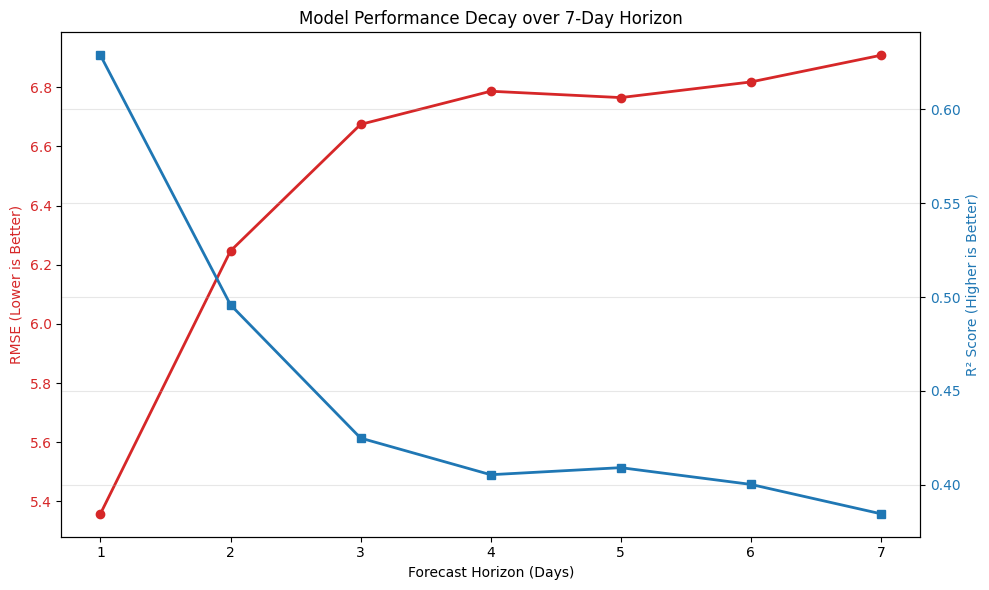

   Day      RMSE        R2
0    1  5.357979  0.628911
1    2  6.246608  0.495856
2    3  6.674352  0.424818
3    4  6.786424  0.405290
4    5  6.764942  0.409056
5    6  6.817802  0.400126
6    7  6.908039  0.384456


In [95]:
import matplotlib.pyplot as plt

# 1. Calculate metrics for each day specifically
individual_metrics = []

for i in range(7):
    # i=0 is Day 1, i=6 is Day 7
    actual = y_test.iloc[:, i]
    predicted = y_pred[:, i]
    
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    individual_metrics.append({
        'Day': i + 1,
        'RMSE': rmse,
        'R2': r2
    })

metrics_df = pd.DataFrame(individual_metrics)

# 2. Plotting the Decay of Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Forecast Horizon (Days)')
ax1.set_ylabel('RMSE (Lower is Better)', color=color)
ax1.plot(metrics_df['Day'], metrics_df['RMSE'], marker='o', color=color, linewidth=2, label='RMSE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('R² Score (Higher is Better)', color=color)
ax2.plot(metrics_df['Day'], metrics_df['R2'], marker='s', color=color, linewidth=2, label='R²')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Model Performance Decay over 7-Day Horizon')
fig.tight_layout()
plt.grid(alpha=0.3)
plt.show()

print(metrics_df)

## rf-lstm

In [99]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 7  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(7) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Windowed UV R2: 0.4190
Windowed UV MSE: 45.1500
Windowed UV RMSE: 6.7194


In [101]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# 

# ]

lstm_feature_cols = FEATURES # change korai lagbe eita naile noise add hobe (therory)

X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(7) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final humidity R2: {rf_lstm_r2:.4f}")
print(f"Final humidity MSE: {rf_lstm_mse:.4f}")
print(f"Final humidity RMSE: {rf_lstm_mse:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
--- HYBRID MODEL PERFORMANCE ---
Final humidity R2: 0.4216
Final humidity MSE: 44.9505
Final humidity RMSE: 44.9505


In [104]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace


X_full = df[FEATURES]
y_full = df[target_cols]

fold = 1
lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf_model.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf_model.predict(X_train_cv)
    
    # [
    # ]

    lstm_feature_cols = FEATURES # change korai lagbe eita naile noise add hobe (therory)

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 7
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(7) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf_model.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")



--- Processing Fold 1 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


ValueError: operands could not be broadcast together with shapes (660,7) (660,) 

## xgboost

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


targets = y
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_xgb = {}


xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)


print(f"\nXGBoost Results for humidity:")
print(f'Mean Squared Error: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')


# K-Fold cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_xgb = []
r2_list_xgb = [] # Added to track R2 across all folds
mse_list_xgb = []

for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]

        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

        mse_list_xgb.append(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        r2_list_xgb.append(r2_kf_xgb)


        average_rmse_xgb = np.mean(rmse_list_xgb)
        average_r2_xgb = np.mean(r2_list_xgb)
        average_mse_xgb = np.mean(mse_kf_xgb)
        

print ("\n")
print(f"Average RMSE from CV: {average_rmse_xgb:.4f}")
print(f"Average R² from CV: {average_r2_xgb:.4f}")
print(f"Avarage MSE: {average_mse_xgb}")
print(f"Individual Fold RMSEs: {rmse_list_xgb}")

# Feature importance for XGBoost
importance = xgb_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

diff = (r2_xgb - average_r2_xgb)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)


## light gbm

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


targets = y
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}


lgb_model = lgb.LGBMRegressor(
        # n_estimators=800,
        # learning_rate=0.01,
        # max_depth=8,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # random_state=42,
        # verbosity=-1

        n_estimators=300,        # Reduced to prevent memorization as UV r 4k dataset
        learning_rate=0.03,      # Slightly faster learning for fewer trees
        max_depth=6,             # Shallow trees are better for 4k rows
        num_leaves=20,           # Controls complexity
        min_child_samples=40,    # Ensures each "leaf" represents enough data
        subsample=0.7,           # More aggressive sampling for better generalization
        colsample_bytree=0.7,    # Uses 70% of features per tree
        random_state=42,
        verbosity=-1
                              # Clean console
    )

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print(f"\nLightGBM Results for humidity:")
print(f'Mean Squared Error: {mse_lgb:.4f}')
print(f'RMSE: {rmse_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')


    # --- 6) 5-fold CV R^2 ---
tscv = TimeSeriesSplit(n_splits=5)
    
rmse_list_lgb = []
r2_list_lgb = []
mse_list_lgb = []


for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        lgb_model_kf = lgb.LGBMRegressor(
            
            n_estimators=300,        # Reduced to prevent memorization
            learning_rate=0.03,      # Slightly faster learning for fewer trees
            max_depth=6,             # Shallow trees are better for 4k rows
            num_leaves=20,           # Controls complexity
            min_child_samples=40,    # Ensures each "leaf" represents enough data
            subsample=0.7,           # More aggressive sampling for better generalization
            colsample_bytree=0.7,    # Uses 70% of features per tree
            random_state=42,
            verbosity=-1             # Clean console
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)
        
        mse_list_lgb.append(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        r2_list_lgb.append(r2_kf_lgb)

        average_rmse_lgb = np.mean(rmse_list_lgb)
        average_r2_lgb = np.mean(r2_list_lgb)
        average_mse_lgb = np.mean(mse_kf_lgb)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_lgb:.4f}")
print(f"Average R² from CV: {average_r2_lgb:.4f}")
print(f"Avarage MSE: {average_mse_lgb}")
print(f"Individual Fold RMSEs: {rmse_list_lgb}")

# Feature importance for LightGBM
importance = lgb_model.feature_importances_
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

diff = (r2_lgb - average_r2_lgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLightGBM Feature Importances:")
print(feature_importance_df_lgb)



## catboost

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split


targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for temperature :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)

        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# Feature importance for LightGBM
importance = cat_model.feature_importances_
feature_names = X.columns
feature_importance_df_cat = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    


## gru

In [ ]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create an instance with specific parameters
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Wait 15 epochs for improvement before stopping
    restore_best_weights=True  # Very important: keeps the best version of your model
)

# 1. Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y) 

# 2. Reshape for GRU: (samples, time_steps, features)
# Here we use time_steps=1. If you want sequences, you'd need a sliding window function.
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data (matching your non-shuffle 80/20 split)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(7) # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train initial model
gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
gru_model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping], 
    verbose=1
)

# Predict and Inverse Scale
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

mse_gru = mean_squared_error(y_test_unscaled, y_pred)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_unscaled, y_pred)

print(f"\nGRU Results for humidity :")
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'RMSE: {rmse_gru:.4f}')
print(f'R² Score: {r2_gru:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild/Reset model for each fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = gru_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_gru = np.mean(r2_list_gru)
average_mse_gru = np.mean(mse_list_gru)
average_rmse_gru = np.mean(rmse_list_gru)

print("\n")
print(f"Average RMSE from CV: {average_rmse_gru:.4f}")
print(f"Average R² from CV: {average_r2_gru:.4f}")
print(f"Average MSE: {average_mse_gru:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_gru}")

diff = (r2_gru - np.mean(r2_list_gru))*100
print ( f'\n R2 ~ {diff:.4f}')

In [ ]:
# Permutation Importance Implementation

import pandas as pd
import numpy as np

def calculate_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Calculates importance by measuring how much the MSE increases 
    when a single feature is randomly shuffled.
    """
    # Baseline prediction
    baseline_preds = model.predict(X_val, verbose=0)
    baseline_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                     scaler_y.inverse_transform(baseline_preds))
    
    importances = []
    
    for i in range(X_val.shape[2]):  # Iterate through each feature
        save = X_val[:, :, i].copy()
        
        # Shuffle the current feature across all samples
        np.random.shuffle(X_val[:, :, i])
        
        # Predict with shuffled feature
        shuffled_preds = model.predict(X_val, verbose=0)
        shuffled_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                         scaler_y.inverse_transform(shuffled_preds))
        
        # Importance is the increase in error
        importances.append(max(0, shuffled_mse - baseline_mse))
        
        # Restore the original feature values
        X_val[:, :, i] = save

    # Create DataFrame
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    return importance_df.sort_values(by='Importance', ascending=False)

# --- Execute ---
# Note: Use your X_test and y_test from the previous step
feature_importance_gru = calculate_permutation_importance(
    gru_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)


print("\nGRU Permutation Feature Importances:")
print(feature_importance_gru)

## lstm

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# 1. Scale Features and Target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for LSTM: [samples, time_steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split matching your CatBoost logic (shuffle=False)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

# Initial Training
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\nLSTM Results for humidity :")
print(f'Mean Squared Error: {mse_lstm:.4f}')    
print(f'RMSE: {rmse_lstm:.4f}')
print(f'R² Score: {r2_lstm:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_lstm = []
r2_list_lstm = []
mse_list_lstm = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Re-instantiate model for each fold
    lstm_kf = build_lstm((X_train_kf.shape[1], X_train_kf.shape[2]))
    lstm_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = lstm_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_lstm.append(np.sqrt(mse_kf))
    mse_list_lstm.append(mse_kf)
    r2_list_lstm.append(r2_score(y_test_kf_unscaled, y_pred_kf))


average_r2_lstm = np.mean(r2_list_lstm)
average_mse_lstm = np.mean(mse_list_lstm)
average_rmse_lstm = np.mean(rmse_list_lstm)
 
print("\n")
print(f"Average RMSE from LSTM CV: {average_rmse_lstm:.4f}")
print(f"Average R² from LSTM CV: { average_r2_lstm:.4f}")
print(f"Average MSE: {average_mse_lstm:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_lstm}")

def calculate_lstm_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Computes permutation importance for a trained LSTM model.
    """
    # 1. Get baseline score (Inverse scale to get real-world MSE)
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    
    # Iterate through each feature index
    for i in range(X_val.shape[2]):
        # Create a copy to avoid permanent shuffling
        X_permuted = X_val.copy()
        
        # 2. Shuffle the specific feature across all samples
        # Shuffling happens across the 'samples' dimension for the i-th feature
        np.random.shuffle(X_permuted[:, :, i])
        
        # 3. Predict with the permuted feature
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        # 4. Importance = Increase in Error (shuffled error - baseline error)
        importance = max(0, permuted_mse - baseline_mse)
        importance_results.append(importance)

    # Organize into a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': importance_results
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

# --- Execution ---
# Using the X_test and y_test from your LSTM training
lstm_importance_df = calculate_lstm_permutation_importance(
    lstm_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)

diff = (r2_lstm - np.mean(r2_list_lstm))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLSTM Permutation Feature Importances:")
print(lstm_importance_df)

## ann

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for humidity :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

## cnn-lstm

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['humidity'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")
print ()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # Added for normalization
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# 1. SCALING AND DATA PREPARATION
window = 30
# Initialize scalers for features (X) and target (y)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale features and target separately
scaled_features = scaler_X.fit_transform(df[FEATURES])
scaled_target = scaler_y.fit_transform(df[['humidity']])  

# Combine scaled data back for sequence creation
data_all_scaled = np.hstack((scaled_features, scaled_target))

def create_sequences_multivariate(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), :-1]) 
        y.append(data[i + window_size, -1]) 
    return np.array(X), np.array(y)

X, y = create_sequences_multivariate(data_all_scaled, window)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 2. UPDATED HYBRID MODEL (No changes needed to architecture)
def build_hybrid_multivariate(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

model = build_hybrid_multivariate((window, len(FEATURES)))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 3. PERFORMANCE EVALUATION (With Inverse Scaling)
y_pred_scaled = model.predict(X_test)
# Convert predictions and actuals back to original Celsius values
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

mse_final = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_final = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"\nRescaled Results: R2: {r2_final:.4f}, RMSE: {np.sqrt(mse_final):.4f}")

# 4. PERMUTATION IMPORTANCE (Standard logic remains)
def get_permutation_importance(model, X_val, y_val, feature_names):
    base_preds = model.predict(X_val, verbose=0)
    base_rmse = np.sqrt(mean_squared_error(y_val, base_preds))
    importance_results = []

    for i, col_name in enumerate(feature_names):
        scores = []
        for run in range(5):
            X_shuffled = X_val.copy()
            shuffled_feature = np.random.permutation(X_shuffled[:, :, i].flatten())
            X_shuffled[:, :, i] = shuffled_feature.reshape(X_shuffled.shape[0], X_shuffled.shape[1])
            shuff_preds = model.predict(X_shuffled, verbose=0)
            shuff_rmse = np.sqrt(mean_squared_error(y_val, shuff_preds))
            scores.append(shuff_rmse - base_rmse)
        
        importance_results.append({
            'Feature': col_name,
            'Average_Importance': np.mean(scores),
            'Std_Dev': np.std(scores)
        })
        print(f"Computed importance for: {col_name}")

    return pd.DataFrame(importance_results).sort_values(by='Average_Importance', ascending=False)

importance_df_hybrid = get_permutation_importance(model, X_test, y_test, FEATURES)
print("\n--- Hybrid Model Feature Importance ---")
print(importance_df_hybrid)

## model chart humidity

In [ ]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [True, True])

print (df_performance)

## best model humidty

In [ ]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'MSE': 0.3,
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['MSE'].rank(ascending=True) * weights['MSE'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE']  +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")

# dewpoint

## rf

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'hum_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


## rf-lstm

## xgboost

## light gbm

## catboost

## gru

## lstm

## ann

## cnn-lstm

## model chart dew point

## best model dewpoint

# solar radiation

## rf

## rf-lstm

## xgboost

## light gbm

## catboost

## gru

## lstm

## ann

## cnn-lstm

## model chart solar

## best model solar